In [43]:

import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt


# class NeurofluxModel:
#     def __init__(self, model_type='pretrained', save_path=None):
#         self.model_type = model_type
#         self.save_path = save_path
#         self.model = None
#         self.history = None
        
#         if self.model_type == 'pretrained':
#             self.model = self._get_pretrained_model()
#         elif self.model_type == 'scratch':
#             self.model = self._get_scratch_model()
    
#     def _get_pretrained_model(self):
#         base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
#         x = base_model.output
#         x = tf.keras.layers.GlobalAveragePooling2D()(x)
#         x = tf.keras.layers.Dense(1024, activation='relu')(x)
#         predictions = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)
#         model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
        
#         for layer in base_model.layers:
#             layer.trainable = False
        
#         return model
    
#     def _get_scratch_model(self):
#         model = tf.keras.models.Sequential([
#             tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
#             tf.keras.layers.MaxPooling2D((2, 2)),
#             tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#             tf.keras.layers.MaxPooling2D((2, 2)),
#             tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#             tf.keras.layers.MaxPooling2D((2, 2)),
#             tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#             tf.keras.layers.MaxPooling2D((2, 2)),
#             tf.keras.layers.Flatten(),
#             tf.keras.layers.Dense(512, activation='relu'),
#             tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
#         ])
        
#         return model
    
#     def train(self, train_data, val_data, epochs=10, batch_size=32, learning_rate=1e-3):
#         self.model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
#                            loss='categorical_crossentropy', 
#                            metrics=['accuracy'])
        
#         self.history = self.model.fit(train_data, 
#                                       epochs=epochs, 
#                                       validation_data=val_data, 
#                                       batch_size=batch_size,
#                                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])
        
#         if self.save_path is not None:
#             self.model.save(self.save_path)
    
#     def evaluate(self, test_data):
#         loss, accuracy = self.model.evaluate(test_data)
#         print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')
    
#     def predict(self, image_path):
#         img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
#         img_array = tf.keras.preprocessing.image.img_to_array(img)
#         img_array = tf.expand_dims(img_array, 0) / 255.
#         prediction = self.model.predict(img_array)[0]
#         predicted_class_index = np.argmax(prediction)
#         predicted_class = CLASS_NAMES[predicted_class_index]
#         return predicted_class
 

class NeurofluxModel:
    def __init__(self, model_type='pretrained', save_path=None):
        self.model_type = model_type
        self.save_path = save_path
        self.model = None
        self.history = None
        
        if self.model_type == 'pretrained':
            self.model = self._get_pretrained_model()
        elif self.model_type == 'scratch':
            self.model = self._get_scratch_model()
    
    def _get_pretrained_model(self):
        base_model = tf.keras.applications.ResNet152V2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
        for layer in base_model.layers[:-15]:
            layer.trainable = False

        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(units=512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(units=512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        output  = tf.keras.layers.Dense(units=5, activation='softmax')(x)
        model = tf.keras.Model(base_model.input, output)
                
        return model
    
    def _get_scratch_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
        ])
        
        return model
    
    def train(self, train_data, val_data, epochs=10, batch_size=32, learning_rate= 0.001):
        class_weights = {
            0: 1.0,  # class 1
            1: 3.0,  # class 2
            2: 2.0,  # class 3
            3: 1.5,  # class 4
            4: 1.0   # class 5
        }

        loss = tf.keras.losses.CategoricalCrossentropy(class_weights)
        optimizerLR = tf.keras.optimizers.Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizerLR, 
                           loss=loss, 
                           metrics=['accuracy', 'Precision', 'Recall'])
        self.history = self.model.fit(train_data, 
                                      epochs=epochs, 
                                      validation_data=val_data, 
                                      batch_size=batch_size,
                                      callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])
        
        if self.save_path is not None:
            self.model.save(self.save_path)
    
    def evaluate(self, test_data):
        results = self.model.evaluate(test_data, return_dict=True)
        loss = results['loss']
        accuracy = results['accuracy']
        print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')
    
    def predict(self, image_path):
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) / 255.
        prediction = self.model.predict(img_array)[0]
        predicted_class_index = np.argmax(prediction)
        predicted_class = CLASS_NAMES[predicted_class_index]
        return predicted_class

# plot history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    



train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    rescale=1./255)

valid_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    rescale=1./255)


# get class names
CLASS_NAMES = ['EO', 'IO', 'IPTE', 'LO', 'PTE']

# Oversample minority classes
class_weights = {0: 1, 1: 3, 2: 2, 3: 1, 4: 1}

# Training
SEED = 1234
tf.random.set_seed(SEED) 

train_gen = train_data_gen.flow_from_directory('./data_split/train',
                                               target_size=(256, 256),
                                               batch_size=32,
                                               classes = CLASS_NAMES,
                                               class_mode='categorical',
                                               shuffle = True,
                                               seed = SEED,
                                                ) 

valid_gen = valid_data_gen.flow_from_directory('./data_split/validation',
                                           target_size=(256, 256),
                                           batch_size=32, 
                                           classes=CLASS_NAMES,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    './data_split/test',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)









Found 908 images belonging to 5 classes.
Found 201 images belonging to 5 classes.
Found 187 files belonging to 5 classes.


In [46]:
model = NeurofluxModel(model_type='pretrained', save_path='./models/pretrained_ResNet152V2.h5')
model.train(train_gen, valid_gen, epochs=10, batch_size=32, learning_rate=0.001)

Epoch 1/10
29/29 [==============================] - 128s 4s/step - loss: 1.4655 - accuracy: 0.4295 - precision: 0.5133 - recall: 0.1278 - val_loss: 7.8298 - val_accuracy: 0.4428 - val_precision: 0.4428 - val_recall: 0.4428
Epoch 2/10
29/29 [==============================] - 118s 4s/step - loss: 1.4396 - accuracy: 0.4493 - precision: 0.4268 - recall: 0.0771 - val_loss: 4.1941 - val_accuracy: 0.4478 - val_precision: 0.4478 - val_recall: 0.4478
Epoch 3/10
29/29 [==============================] - 115s 4s/step - loss: 1.3985 - accuracy: 0.4471 - precision: 0.5646 - recall: 0.1685 - val_loss: 5.1277 - val_accuracy: 0.4478 - val_precision: 0.4478 - val_recall: 0.4478
Epoch 4/10
29/29 [==============================] - 122s 4s/step - loss: 1.3856 - accuracy: 0.4504 - precision: 0.5830 - recall: 0.1663 - val_loss: 4.0999 - val_accuracy: 0.2637 - val_precision: 0.2640 - val_recall: 0.2587
Epoch 5/10
29/29 [==============================] - 123s 4s/step - loss: 1.3740 - accuracy: 0.4383 - precisi

In [45]:
model.evaluate(test_data)


6/6 [==============================] - 20s 3s/step - loss: 122.2134 - accuracy: 0.4332 - precision: 0.4355 - recall: 0.4332
Test loss: 122.213, Test accuracy: 0.433


In [ ]:
labels = {value: key for key, value in train_gen.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Epoch 1/10


/home/amine/.local/lib/python3.10/site-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


29/29 [==============================] - 20s 643ms/step - loss: 1.4918 - accuracy: 0.4141 - precision: 0.4136 - recall: 0.0870 - val_loss: 1.4203 - val_accuracy: 0.4478 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
29/29 [==============================] - 18s 615ms/step - loss: 1.4168 - accuracy: 0.4504 - precision: 0.3788 - recall: 0.0275 - val_loss: 1.4325 - val_accuracy: 0.4478 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
29/29 [==============================] - 18s 608ms/step - loss: 1.4178 - accuracy: 0.4504 - precision: 0.6154 - recall: 0.0176 - val_loss: 1.4150 - val_accuracy: 0.4478 - val_precision: 0.5714 - val_recall: 0.0199
Epoch 4/10
29/29 [==============================] - 18s 632ms/step - loss: 1.4149 - accuracy: 0.4504 - precision: 0.4815 - recall: 0.0859 - val_loss: 1.4224 - val_accuracy: 0.4478 - val_precision: 1.0000 - val_recall: 0.0050
Epoch 5/10
29/29 [==============================] - 18s 617ms/step - loss: 1.4307 - accuracy: 0

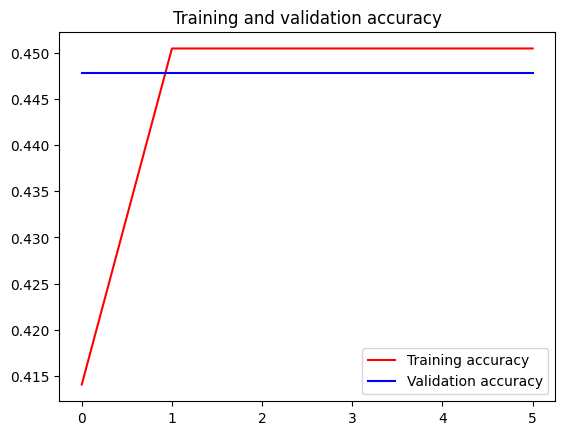

<Figure size 640x480 with 0 Axes>

In [44]:

model2 = NeurofluxModel(model_type='scratch', save_path='./models/scratch.h5')
model2.train(train_gen, valid_gen, epochs=10, batch_size=32, learning_rate=1e-3)
model2.evaluate(test_data)
plot_history(model2.history)


In [12]:
from PIL import Image
import os

# Path to the directory containing the images
data_dir = './data_split/'

# Loop through all the subdirectories (train, test, validation)
for sub_dir in os.listdir(data_dir):
    sub_dir_path = os.path.join(data_dir, sub_dir)
    
    # Loop through all the classes (class1, class2, etc.)
    for class_dir in os.listdir(sub_dir_path):
        class_dir_path = os.path.join(sub_dir_path, class_dir)
        
        # Loop through all the images in the class directory
        # loop through all files in the directory
        for filename in os.listdir(class_dir_path):
            # set the path of the file
            file_path = os.path.join(class_dir_path, filename)

            # get the file name and extension
            file_name, file_ext = os.path.splitext(file_path)
                    
            
            # check if the file extension is ".jpg"
            if file_ext != ".JPEG":
                # rename the file with the new extension
                os.rename(file_path, file_name + ".JPEG")
                print("File extension changed successfully.")

# make the above code as a function
def change_file_extensions(data_dir, new_ext):
    # Loop through all the subdirectories (train, test, validation)
    for sub_dir in os.listdir(data_dir):
        sub_dir_path = os.path.join(data_dir, sub_dir)

        # Loop through all the classes (class1, class2, etc.)
        for class_dir in os.listdir(sub_dir_path):
            class_dir_path = os.path.join(sub_dir_path, class_dir)

            # Loop through all the images in the class directory
            # loop through all files in the directory
            for filename in os.listdir(class_dir_path):
                # set the path of the file
                file_path = os.path.join(class_dir_path, filename)

                # get the file name and extension
                file_name, file_ext = os.path.splitext(file_path)


                # check if the file extension is ".jpg"
                if file_ext != new_ext:
                    # rename the file with the new extension
                    os.rename(file_path, file_name + new_ext)
                    print("File extension changed successfully.")

In [3]:

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2


import numpy as np
import matplotlib.pyplot as plt

def create_model():
    model = Sequential([
        Activation('relu'),
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(256, 256, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=5, activation='softmax')
    ])
    
    return model

cnn_model = create_model()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
history = cnn_model.fit(train_gen, epochs=30, validation_data=valid_gen,
                       verbose=2,
                       callbacks=[reduce_lr])

plot_history(history)


Epoch 1/30
29/29 - 39s - loss: 4.2894 - accuracy: 0.3040 - val_loss: 3.6576 - val_accuracy: 0.1592 - lr: 0.0010 - 39s/epoch - 1s/step
Epoch 2/30
29/29 - 40s - loss: 2.5373 - accuracy: 0.3645 - val_loss: 1.9227 - val_accuracy: 0.2537 - lr: 0.0010 - 40s/epoch - 1s/step
Epoch 3/30
29/29 - 42s - loss: 2.1704 - accuracy: 0.4042 - val_loss: 2.6902 - val_accuracy: 0.2637 - lr: 0.0010 - 42s/epoch - 1s/step
Epoch 4/30
29/29 - 41s - loss: 2.0312 - accuracy: 0.4119 - val_loss: 2.6257 - val_accuracy: 0.4129 - lr: 0.0010 - 41s/epoch - 1s/step
Epoch 5/30
29/29 - 41s - loss: 1.9289 - accuracy: 0.4086 - val_loss: 2.4450 - val_accuracy: 0.4378 - lr: 0.0010 - 41s/epoch - 1s/step
Epoch 6/30
29/29 - 42s - loss: 1.7040 - accuracy: 0.4339 - val_loss: 2.5401 - val_accuracy: 0.4328 - lr: 0.0010 - 42s/epoch - 1s/step
Epoch 7/30
29/29 - 42s - loss: 1.7298 - accuracy: 0.4141 - val_loss: 2.5514 - val_accuracy: 0.3234 - lr: 0.0010 - 42s/epoch - 1s/step
Epoch 8/30


KeyboardInterrupt: 